Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
0 1.35941 0.720907
10 0.748592 1.07245
20 0.673421 0.918424
30 0.770298 1.33065
40 1.04504 0.96285
50 0.723304 1.18683
60 0.423375 1.41957
70 1.34066 4.07458
80 0.799717 1.14632
90 0.651692 1.3255
100 0.996441 0.94631
110 0.924662 0.960521
120 0.981466 1.03513
130 1.07503 1.40487
140 1.5604 0.36777
150 1.13019 1.01831
160 1.07968 1.02729
170 0.998371 0.946844
180 0.998576 1.05842
190 1.07377 1.42765
200 1.02041 1.12236
210 1.07253 0.789711
220 1.07106 1.56469
230 1.15003 1.29671
240 1.11577 1.35275
250 1.75984 0.601552
260 1.28534 0.946627
270 0.917055 1.15946
280 1.1803 0.969949
290 1.48151 0.743051
300 1.499 0.74442
310 1.1558 0.883801
320 1.21496 0.91904
330 1.4246 0.763082
340 1.11985 0.860903
350 1.12084 0.9148
360 1.12774 0.865382
370 1.11613 0.911488
380 1.15895 0.885703
390 1.12806 1.010

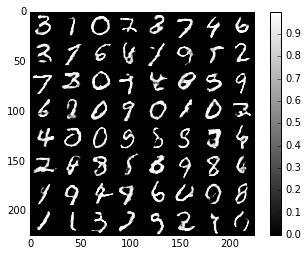

DONE


In [1]:
%matplotlib inline

import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data

import matplotlib
import matplotlib.pyplot as plt

mnist = input_data.read_data_sets( "MNIST_data/", one_hot=True )

#
# -------------------------------------------
#
# Global variables

batch_size = 128
z_dim = 10

#
# ==================================================================
# ==================================================================
# ==================================================================
#

def linear( in_var, output_size, name="linear", stddev=0.02, bias_val=0.0 ):
    shape = in_var.get_shape().as_list()
    
    with tf.variable_scope( name):
        W = tf.get_variable( "W", [shape[1], output_size], tf.float32,
                              tf.random_normal_initializer( stddev=stddev ) )
       
        b = tf.get_variable( "b", [output_size],
                             initializer=tf.constant_initializer( bias_val ))

        return tf.matmul( in_var, W ) + b
    
def lrelu( x, leak=0.2, name="lrelu" ):
    return tf.maximum( x, leak*x )

def deconv2d( in_var, output_shape, name="deconv2d", stddev=0.02, bias_val=0.0 ):
    k_w = 5  # filter width/height
    k_h = 5
    d_h = 2  # x,y strides
    d_w = 2

    # [ height, width, in_channels, number of filters ]
    var_shape = [ k_w, k_h, output_shape[-1], in_var.get_shape()[-1] ]

    with tf.variable_scope( name):   
        W = tf.get_variable( "W", var_shape,
                             initializer=tf.truncated_normal_initializer( stddev=0.02 ) )
        b = tf.get_variable( "b", [output_shape[-1]],
                             initializer=tf.constant_initializer( bias_val ))

        deconv = tf.nn.conv2d_transpose( in_var, W, output_shape=output_shape, strides=[1, d_h, d_w, 1] )
        deconv = tf.reshape( tf.nn.bias_add( deconv, b), deconv.get_shape() )
    
        return deconv

def conv2d( in_var, output_dim, name="conv2d" ):
    k_w = 5  # filter width/height
    k_h = 5
    d_h = 2  # x,y strides
    d_w = 2

    with tf.variable_scope( name):
        W = tf.get_variable( "W", [k_h, k_w, in_var.get_shape()[-1], output_dim],
                             initializer=tf.truncated_normal_initializer(stddev=0.02) )
        b = tf.get_variable( "b", [output_dim], initializer=tf.constant_initializer(0.0) )

        conv = tf.nn.conv2d( in_var, W, strides=[1, d_h, d_w, 1], padding='SAME' )
        conv = tf.reshape( tf.nn.bias_add( conv, b ), conv.get_shape() )

        return conv

#
# ==================================================================
# ==================================================================
# ==================================================================
#

# the generator should accept a (tensor of multiple) 'z' and return an image
# z will be [None,z_dim]

def gen_model( z ):
    with tf.variable_scope( "g_h1" ):
        g_h1 = linear(z, 128*7*7)
        g_h1 = tf.nn.relu(g_h1)
    
    g_h1 = tf.reshape( g_h1, [ batch_size, 7, 7, 128 ] )
    
    with tf.variable_scope( "g_dc2" ):
        g_dc2 = deconv2d( g_h1, [batch_size,14,14,128])
        g_dc2 = tf.nn.relu(g_dc2)
        
    with tf.variable_scope( "g_dc3" ):
        g_dc3 = deconv2d( g_dc2, [batch_size,28,28,1])

    output = tf.nn.sigmoid(g_dc3)

    #reshape to make compatible with discriminator
    output = tf.reshape( output, [ batch_size, 784 ] ) 
    return output #an image!

# -------------------------------------------
    
# the discriminator should accept a (tensor of muliple) images and
# return a probability that the image is real
# imgs will be [None,784]

def disc_model( imgs ):
    #reshaping to make compatible with convolution
    imgs = tf.reshape( imgs, [ batch_size, 28, 28, 1 ] )
        
   
    with tf.variable_scope( "d_h0_conv" ):
        d_h0_con = conv2d( imgs, 32)
        d_h0_con = lrelu(d_h0_con)

    with tf.variable_scope( "d_h1_conv" ):
        d_h1_con = conv2d(d_h0_con, 64)
        d_h1_con = lrelu(d_h1_con)

        #reshaping 2d for linear
        d_h1_con = tf.reshape( d_h1_con, [ batch_size, -1 ] )
        
    with tf.variable_scope( "d_h2_lin" ):
        d_h2_lin = linear( d_h1_con, 1024)
    with tf.variable_scope( "d_h3_lin" ):
        d_h3_lin = linear(d_h2_lin, 1)
        
    output = tf.nn.sigmoid(d_h3_lin)

    return output #Prob(imgs_realImages)

#
# ==================================================================
# ==================================================================
# ==================================================================
#

# Create your computation graph, cost function, and training steps here!

# Placeholders should be named 'z' and ''true_images'
z = tf.placeholder( tf.float32, shape=[None, z_dim], name="z" )
true_images = tf.placeholder( tf.float32, shape=[None, 784], name="true_images" )

# The output of the generator should be named 'sample_images'
with tf.name_scope( "Models" ) as scope:
    with tf.name_scope( "Generator" ) as scope:
        sample_images = gen_model(z)

    with tf.name_scope( "Discriminator" ) as scope:
        prob_true = disc_model(true_images)
        tf.get_variable_scope().reuse_variables()
        prob_diff = disc_model(sample_images)

with tf.name_scope( "Loss" ) as scope:
    # Find the losses for d_loss and g_loss (minimizing the neg -> maximize)
    d_loss = tf.reduce_mean(-1 * (tf.log(prob_true) + tf.log(1 - prob_diff)))
    g_loss = tf.reduce_mean(-1 * (tf.log(prob_diff)))

# Training ops should be named 'd_optim' and 'g_optim'
with tf.name_scope( "Optimizer" ) as scope:
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if 'd_' in var.name]
    d_optim = tf.train.AdamOptimizer( 0.0002, beta1=0.5 ).minimize( d_loss, var_list=d_vars )

    g_vars = [var for var in t_vars if 'g_' in var.name]
    g_optim = tf.train.AdamOptimizer( 0.0002, beta1=0.5 ).minimize( g_loss, var_list=g_vars )

#
# ==================================================================
# ==================================================================
# ==================================================================
#

sess = tf.Session()
sess.run( tf.initialize_all_variables() )
summary_writer = tf.train.SummaryWriter( "./tf_logs", graph=sess.graph )

for i in range( 5000 ):
    batch = mnist.train.next_batch( batch_size )
    batch_images = batch[0]
    
    sampled_zs = np.random.uniform( low=-1, high=1, size=(batch_size, z_dim) ).astype( np.float32 )
    sess.run( d_optim, feed_dict={ z:sampled_zs, true_images: batch_images } )
 

    for j in range(3):
        sampled_zs = np.random.uniform( low=-1, high=1, size=(batch_size, z_dim) ).astype( np.float32 )
        sess.run( g_optim, feed_dict={ z:sampled_zs } )
      
        
    
    if i%10==0:
        d_loss_val,g_loss_val = sess.run( [d_loss,g_loss],
                                                    feed_dict={ z:sampled_zs, true_images: batch_images } )
        print i, d_loss_val, g_loss_val

summary_writer.close()

#
#  show some results
#
sampled_zs = np.random.uniform( -1, 1, size=(batch_size, z_dim) ).astype( np.float32 )
simgs = sess.run( sample_images, feed_dict={ z:sampled_zs } )
simgs = simgs[0:64,:]

tiles = []
for i in range(0,8):
    tiles.append( np.reshape( simgs[i*8:(i+1)*8,:], [28*8,28] ) )
plt.imshow( np.hstack(tiles), interpolation='nearest', cmap=matplotlib.cm.gray )
plt.colorbar()
plt.show()
print "DONE"
